In [1]:
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from utils import *
from preprocessing import Dataset
from adjacency import MatrixBuilder

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [3]:
%load_ext autoreload
%autoreload 2

In [64]:
with gzip.open('data.pickle.gz', 'rb') as fh:
    data = pickle.load(fh, )

In [65]:
dataset = Dataset(data)

In [26]:
V5_same_MB.metrics

{'n_symmetry_checks': 1553, 'n_find_sym_idx': 5806, 'sum_len_to_search': 6843}

In [28]:
V5_same_MB.metrics["sum_len_to_search"] / V5_same_MB.metrics["n_find_sym_idx"]

1.178608336203927

In [29]:
V5_same_MB.metrics["n_symmetry_checks"] / V5_same_MB.metrics["n_find_sym_idx"]

0.2674819152600758

In [6]:
class Result:
    def __init__(self, end, path, reached_global_min):
        self.end = end
        self.path = path
        self.reached_global_min = reached_global_min
        
    def __repr__(self):
        return f'end: {self.end}, path: {self.path}, reached_global_min: {self.reached_global_min}.'
        
class GroupResult:
    def __init__(self, name):
        self.name = name
    
    def build(self, adj_dict, dataset):
        self.adj_dict = adj_dict
        self.min_e_idx = int(dataset.energy_argmin_idx(self.name))
        self.graph = nx.from_dict_of_lists(adj_dict, create_using=nx.DiGraph)
        self.local_mins = set(node for node in self.graph.nodes
                           if self.graph.out_degree(node) == 0) - set([self.min_e_idx])
        self.reached_global_min = []
        self.not_reached_global_min = []
        self.results = {}
        for node in self.graph.nodes:
            if nx.has_path(self.graph, node, self.min_e_idx):
                self.results[node] = Result(
                    self.min_e_idx,
                    nx.shortest_path(self.graph, node, self.min_e_idx),
                    True
                )
                if node != self.min_e_idx:
                    self.reached_global_min.append(node)
            else:
                reachable_loc_mins = [loc_min for loc_min in self.local_mins
                                     if nx.has_path(self.graph, node, loc_min)]
                energies = [dataset[loc_min].formation_energy for loc_min in reachable_loc_mins]
                deepest_loc_min = reachable_loc_mins[np.argmin(energies)]
                self.results[node] = Result(
                    int(deepest_loc_min),
                    nx.shortest_path(self.graph, node, deepest_loc_min),
                    False
                )
                if node not in self.local_mins:
                    self.not_reached_global_min.append(node)
                    

In [7]:
def get_results(name):
    MB = MatrixBuilder(dataset, name)
    ad = MB.generate_group_adj_dict(how="DG", n_jobs=1)
    gr = GroupResult(name)
    gr.build(ad, dataset)
    return gr

In [8]:
MB = MatrixBuilder(dataset, "V5_diff")

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


In [11]:
ad = MB.generate_group_adj_dict(how="DG", n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 11

[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 217 out of 217 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 218 out of 21

[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 310 out of 310 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 321 out of 32

In [10]:
MB.metrics

{'n_symmetry_checks': 38, 'n_find_sym_idx': 6, 'sum_len_to_search': 79}

In [14]:
dataset.data.subgroup.unique()

array(['X1', 'X2_diff', 'X3', 'X4_diff', 'X4_same', 'X5_diff', 'V1',
       'X5_same', 'V2', 'V3_same', 'X2_same', 'V4', 'V3_diff', 'V5_diff',
       'V5_same', 'V6_same', 'S1', 'S2', 'V6_diff', 'S3_same', 'S4',
       'S5_same', 'S6_same', 'S5_diff', 'S3_diff', 'S6_diff'],
      dtype=object)

In [21]:
def timeit():
    for group in dataset.data.subgroup.unique():
        if len(dataset[group]) > 1:
            print(group)
            MB = MatrixBuilder(dataset, group)
            ad = MB.generate_group_adj_dict(how="DG", n_jobs=1)
            save_adj_dict(ad, group)
            metrics["n_symmetry_checks"] += MB.metrics["n_symmetry_checks"]
            metrics["n_find_sym_idx"] += MB.metrics["n_find_sym_idx"]
            metrics["sum_len_to_search"] += MB.metrics["sum_len_to_search"]

In [43]:
metrics = {"n_symmetry_checks" : 0, 
           "n_find_sym_idx": 0,
           "sum_len_to_search": 0,
           "estimated_n_checks": 0}    

In [30]:
%time timeit()

X2_diff
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.9s finished
X4_diff
[Parallel(n_jobs=1)]: Using backe

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   30.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   31.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   35.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   36.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   38.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   39.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   43.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   44.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   45.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  3

[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 133 out of 13

[Parallel(n_jobs=1)]: Done 224 out of 224 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 229 out of 229 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 236 out of 23

[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 329 out of 329 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 331 out of 331 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 334 out of 334 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 339 out of 33

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  4

[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 15

[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 25

[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 346 out of 346 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:  9.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:  9.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  9.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 35

[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  7

[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 182 out of 18

[Parallel(n_jobs=1)]: Done 273 out of 273 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 274 out of 274 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 277 out of 277 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 279 out of 279 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 285 out of 28

[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 377 out of 377 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  7.9min finished
V5_same
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7

[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 11

[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 202 out of 202 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 213 out of 21

[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 310 out of 310 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 316 out of 31

[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  5

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 156 out of 15

[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 25

[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 362 out of 36

[Parallel(n_jobs=1)]: Done 453 out of 453 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 454 out of 454 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed: 26.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 456 out of 456 | elapsed: 26.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 457 out of 457 | elapsed: 26.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed: 26.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed: 26.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed: 26.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed: 26.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed: 26.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed: 26.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 464 out of 464 | elapsed: 26.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 465 out of 46

[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed: 32.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed: 32.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 562 out of 562 | elapsed: 32.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 563 out of 563 | elapsed: 32.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 564 out of 564 | elapsed: 32.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 565 out of 565 | elapsed: 32.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 566 out of 566 | elapsed: 32.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 567 out of 567 | elapsed: 32.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 568 out of 56

[Parallel(n_jobs=1)]: Done 659 out of 659 | elapsed: 37.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 660 out of 660 | elapsed: 37.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed: 37.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 662 out of 662 | elapsed: 37.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 663 out of 663 | elapsed: 37.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 664 out of 664 | elapsed: 38.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed: 38.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 666 out of 666 | elapsed: 38.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed: 38.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed: 38.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed: 38.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed: 38.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 671 out of 67

[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  5

[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 158 out of 15

[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 261 out of 26

[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed: 20.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 362 out of 362 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 363 out of 363 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 36

[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 456 out of 456 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 457 out of 457 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed: 26.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed: 26.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed: 26.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 464 out of 464 | elapsed: 26.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 465 out of 465 | elapsed: 26.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 466 out of 466 | elapsed: 26.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 467 out of 46

[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed: 31.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed: 31.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed: 31.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed: 31.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 562 out of 562 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 563 out of 563 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 564 out of 564 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 565 out of 565 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 566 out of 566 | elapsed: 32.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 567 out of 567 | elapsed: 32.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 568 out of 568 | elapsed: 32.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 569 out of 569 | elapsed: 32.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 570 out of 57

[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed: 37.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 662 out of 662 | elapsed: 37.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 663 out of 663 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 664 out of 664 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 666 out of 666 | elapsed: 37.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed: 37.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed: 37.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed: 37.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed: 37.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 671 out of 671 | elapsed: 37.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed: 38.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 673 out of 67

[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  5

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 162 out of 16

[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 265 out of 26

[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 362 out of 362 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 363 out of 363 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:  7.9min finished
S4
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | el

[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  8

[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 186 out of 186 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 191 out of 19

[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 286 out of 286 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 292 out of 292 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 294 out of 29

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   52.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   55.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   58.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  3

[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 134 out of 13

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 229 out of 229 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed: 11.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 236 out of 236 | elapsed: 11.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 237 out of 23

[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed: 15.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 329 out of 329 | elapsed: 15.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed: 15.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 331 out of 331 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 334 out of 334 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 339 out of 339 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 340 out of 34

[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 434 out of 434 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 436 out of 436 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 437 out of 437 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 438 out of 438 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 439 out of 439 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed: 21.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 441 out of 441 | elapsed: 21.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 442 out of 442 | elapsed: 21.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 443 out of 44

[Parallel(n_jobs=1)]: Done 534 out of 534 | elapsed: 25.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 535 out of 535 | elapsed: 25.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed: 25.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 537 out of 537 | elapsed: 25.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 538 out of 538 | elapsed: 25.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 539 out of 539 | elapsed: 25.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 542 out of 542 | elapsed: 25.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 543 out of 543 | elapsed: 25.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 544 out of 544 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 545 out of 545 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 546 out of 54

[Parallel(n_jobs=1)]: Done 637 out of 637 | elapsed: 30.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 638 out of 638 | elapsed: 30.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 639 out of 639 | elapsed: 30.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 641 out of 641 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 642 out of 642 | elapsed: 30.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 643 out of 643 | elapsed: 30.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 644 out of 644 | elapsed: 30.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 645 out of 645 | elapsed: 30.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 646 out of 646 | elapsed: 30.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 647 out of 647 | elapsed: 30.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 30.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 649 out of 64

[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   46.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   47.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   48.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:   49.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   51.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   52.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:   53.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   54.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:   55.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:   56.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   57.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:   58.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  5

[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 15

[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 25

[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 35

[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  8

[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 184 out of 18

[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 277 out of 277 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 279 out of 279 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 286 out of 286 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 287 out of 28

[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  8.5min finished
S6_diff
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 11

[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed: 10.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed: 10.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 215 out of 21

[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 310 out of 310 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed: 15.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed: 15.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 318 out of 31

[Parallel(n_jobs=1)]: Done 409 out of 409 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 410 out of 410 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 411 out of 411 | elapsed: 19.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 412 out of 412 | elapsed: 19.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 413 out of 413 | elapsed: 19.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 414 out of 414 | elapsed: 19.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 415 out of 415 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 416 out of 416 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 417 out of 417 | elapsed: 19.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 418 out of 418 | elapsed: 19.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 419 out of 419 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 421 out of 42

[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed: 24.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 513 out of 513 | elapsed: 24.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 514 out of 514 | elapsed: 24.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 515 out of 515 | elapsed: 24.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 516 out of 516 | elapsed: 24.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 517 out of 517 | elapsed: 24.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 518 out of 518 | elapsed: 24.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 519 out of 519 | elapsed: 24.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 520 out of 520 | elapsed: 24.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 521 out of 521 | elapsed: 24.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed: 24.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 523 out of 523 | elapsed: 25.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 524 out of 52

[Parallel(n_jobs=1)]: Done 615 out of 615 | elapsed: 29.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 616 out of 616 | elapsed: 29.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 617 out of 617 | elapsed: 29.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 618 out of 618 | elapsed: 29.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed: 29.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 620 out of 620 | elapsed: 29.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 621 out of 621 | elapsed: 29.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 622 out of 622 | elapsed: 29.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 623 out of 623 | elapsed: 29.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 624 out of 624 | elapsed: 29.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 29.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 626 out of 626 | elapsed: 29.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 627 out of 62

In [41]:
def timeit_load():
    for group in dataset.data.subgroup.unique():
        if len(dataset[group]) > 1:
            print(group)
            MB = MatrixBuilder(dataset, group)
            ad = MB.generate_group_adj_dict(how="DG", n_jobs=1)
            sample_ad = restore_adj_dict(group)
            assert len(deepdiff.DeepDiff(ad, sample_ad, 
                                         ignore_numeric_type_changes=True, 
                                         ignore_order=True)) == 0
            metrics["n_symmetry_checks"] += MB.metrics["n_symmetry_checks"]
            metrics["n_find_sym_idx"] += MB.metrics["n_find_sym_idx"]
            metrics["sum_len_to_search"] += MB.metrics["sum_len_to_search"]
            metrics["estimated_n_checks"] += MB.metrics["n_symmetry_checks"] * len(dataset[group])

In [44]:
%time timeit_load()

X2_diff
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
X4_diff
[Parallel(n_jobs=1)]: Using backe

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   24.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   29.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   30.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   32.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   33.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   35.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   36.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   37.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  3

[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 133 out of 13

[Parallel(n_jobs=1)]: Done 224 out of 224 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 229 out of 229 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 236 out of 23

[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 329 out of 329 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 331 out of 331 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 334 out of 334 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 339 out of 33

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   51.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   52.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   54.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   55.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   57.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:   58.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   60.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  4

[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 15

[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 25

[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 346 out of 346 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 35

[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  7

[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 182 out of 18

[Parallel(n_jobs=1)]: Done 273 out of 273 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 274 out of 274 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 277 out of 277 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 279 out of 279 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 285 out of 28

[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 377 out of 377 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  7.7min finished
V5_same
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7

[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 11

[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 202 out of 202 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 213 out of 21

[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 310 out of 310 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 316 out of 31

[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  5

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 156 out of 15

[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 25

[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed: 19.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed: 19.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed: 20.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed: 20.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 362 out of 36

[Parallel(n_jobs=1)]: Done 453 out of 453 | elapsed: 25.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 454 out of 454 | elapsed: 25.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 456 out of 456 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 457 out of 457 | elapsed: 25.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 464 out of 464 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 465 out of 46

[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed: 31.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed: 31.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed: 31.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed: 31.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed: 31.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed: 31.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 562 out of 562 | elapsed: 31.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 563 out of 563 | elapsed: 31.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 564 out of 564 | elapsed: 31.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 565 out of 565 | elapsed: 31.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 566 out of 566 | elapsed: 31.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 567 out of 567 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 568 out of 56

[Parallel(n_jobs=1)]: Done 659 out of 659 | elapsed: 37.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 660 out of 660 | elapsed: 37.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed: 37.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 662 out of 662 | elapsed: 37.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 663 out of 663 | elapsed: 37.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 664 out of 664 | elapsed: 37.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed: 37.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 666 out of 666 | elapsed: 37.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 671 out of 67

[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  5

[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 158 out of 15

[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 261 out of 26

[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 362 out of 362 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 363 out of 363 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 36

[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 456 out of 456 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 457 out of 457 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed: 26.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed: 26.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed: 26.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed: 26.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 464 out of 464 | elapsed: 26.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 465 out of 465 | elapsed: 26.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 466 out of 466 | elapsed: 26.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 467 out of 46

[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed: 31.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed: 31.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed: 31.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 562 out of 562 | elapsed: 32.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 563 out of 563 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 564 out of 564 | elapsed: 32.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 565 out of 565 | elapsed: 32.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 566 out of 566 | elapsed: 32.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 567 out of 567 | elapsed: 32.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 568 out of 568 | elapsed: 32.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 569 out of 569 | elapsed: 32.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 570 out of 57

[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 662 out of 662 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 663 out of 663 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 664 out of 664 | elapsed: 37.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed: 37.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 666 out of 666 | elapsed: 37.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed: 37.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed: 37.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed: 37.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed: 38.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 671 out of 671 | elapsed: 38.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed: 38.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 673 out of 67

[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:   57.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   58.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  5

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 162 out of 16

[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 265 out of 26

[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 362 out of 362 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 363 out of 363 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:  7.0min finished
S4
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | el

[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  8

[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 186 out of 186 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 191 out of 19

[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 286 out of 286 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 292 out of 292 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 294 out of 29

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   53.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   56.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   59.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  3

[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 134 out of 13

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 229 out of 229 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed: 11.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed: 11.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed: 11.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 236 out of 236 | elapsed: 11.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 237 out of 23

[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed: 15.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 329 out of 329 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 331 out of 331 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 334 out of 334 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 339 out of 339 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 340 out of 34

[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 434 out of 434 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 436 out of 436 | elapsed: 21.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 437 out of 437 | elapsed: 21.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 438 out of 438 | elapsed: 21.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 439 out of 439 | elapsed: 21.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed: 21.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 441 out of 441 | elapsed: 21.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 442 out of 442 | elapsed: 21.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 443 out of 44

[Parallel(n_jobs=1)]: Done 534 out of 534 | elapsed: 25.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 535 out of 535 | elapsed: 25.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 537 out of 537 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 538 out of 538 | elapsed: 25.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 539 out of 539 | elapsed: 25.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 542 out of 542 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 543 out of 543 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 544 out of 544 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 545 out of 545 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 546 out of 54

[Parallel(n_jobs=1)]: Done 637 out of 637 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 638 out of 638 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 639 out of 639 | elapsed: 30.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed: 30.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 641 out of 641 | elapsed: 30.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 642 out of 642 | elapsed: 30.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 643 out of 643 | elapsed: 30.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 644 out of 644 | elapsed: 30.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 645 out of 645 | elapsed: 30.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 646 out of 646 | elapsed: 30.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 647 out of 647 | elapsed: 30.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 30.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 649 out of 64

[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   50.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   51.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   52.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:   54.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   56.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:   57.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   58.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  5

[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 153 out of 15

[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 25

[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 359 out of 35

[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  8

[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 184 out of 18

[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 277 out of 277 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 279 out of 279 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 286 out of 286 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 287 out of 28

[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:  7.4min finished
S6_diff
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 11

[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:  9.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 215 out of 21

[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 310 out of 310 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 318 out of 31

[Parallel(n_jobs=1)]: Done 409 out of 409 | elapsed: 19.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 410 out of 410 | elapsed: 19.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 411 out of 411 | elapsed: 19.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 412 out of 412 | elapsed: 19.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 413 out of 413 | elapsed: 19.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 414 out of 414 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 415 out of 415 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 416 out of 416 | elapsed: 19.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 417 out of 417 | elapsed: 19.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 418 out of 418 | elapsed: 19.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 419 out of 419 | elapsed: 19.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 421 out of 42

[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed: 24.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 513 out of 513 | elapsed: 24.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 514 out of 514 | elapsed: 24.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 515 out of 515 | elapsed: 24.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 516 out of 516 | elapsed: 24.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 517 out of 517 | elapsed: 24.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 518 out of 518 | elapsed: 24.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 519 out of 519 | elapsed: 24.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 520 out of 520 | elapsed: 24.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 521 out of 521 | elapsed: 24.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed: 24.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 523 out of 523 | elapsed: 24.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 524 out of 52

[Parallel(n_jobs=1)]: Done 615 out of 615 | elapsed: 28.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 616 out of 616 | elapsed: 29.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 617 out of 617 | elapsed: 29.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 618 out of 618 | elapsed: 29.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed: 29.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 620 out of 620 | elapsed: 29.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 621 out of 621 | elapsed: 29.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 622 out of 622 | elapsed: 29.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 623 out of 623 | elapsed: 29.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 624 out of 624 | elapsed: 29.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 29.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 626 out of 626 | elapsed: 29.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 627 out of 62

In [36]:
sample_V2_ad = restore_adj_dict('V2')

In [37]:
import deepdiff
diff = deepdiff.DeepDiff(ad, sample_V2_ad, 
                         ignore_numeric_type_changes=True, ignore_order=True)
diff

{}

In [31]:
metrics

{'n_symmetry_checks': 87350,
 'n_find_sym_idx': 93164,
 'sum_len_to_search': 161906}

In [12]:
gr = GroupResult("V5_diff")
%time gr.build(ad, dataset)

CPU times: user 48.9 ms, sys: 866 µs, total: 49.7 ms
Wall time: 48 ms


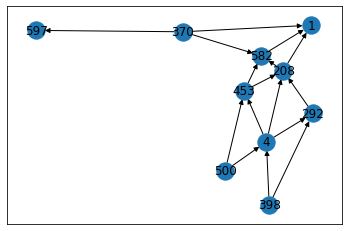

In [134]:
nx.draw_networkx(x2_diff.graph)

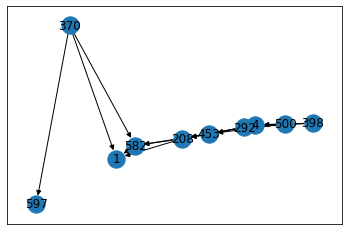

In [217]:
nx.draw_networkx(x2_diff.graph, pos=generate_positions(x2_diff, dataset))


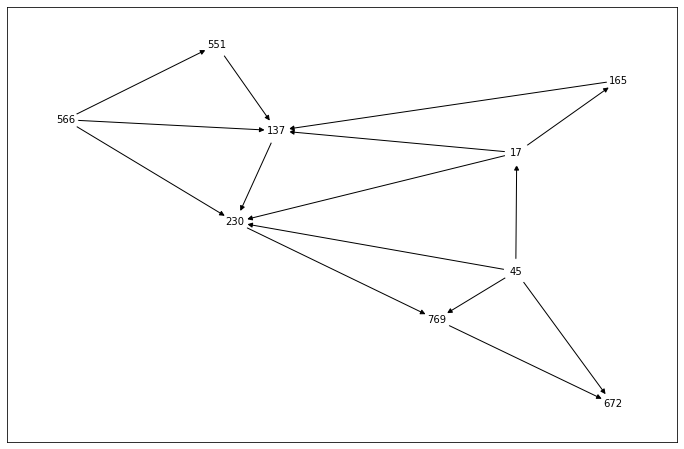

In [228]:
plt.figure(figsize=(12,8))
options = {
    "node_size": 600,
    "node_color": "white",
    "font_size": 10
}
nx.draw_networkx(x2_same.graph, **options)
    

In [222]:
x2_diff.adj_dict

{1: [],
 4: [292, 208, 453],
 208: [1, 582],
 292: [208],
 370: [1, 582, 597],
 398: [4, 292],
 453: [208, 582],
 500: [4, 453],
 582: [1],
 597: []}

In [198]:
def generate_positions(gr, dataset):
    def get_distance(idx):
        defect_repr = dataset[idx].defect_representation
        return defect_repr[0].distance(defect_repr[1])
    def get_energy(idx):
        return dataset[idx].formation_energy
    positions = {}
    for node in gr.graph:
        positions[node] = ( get_distance(node), get_energy(node) )
    return positions

In [45]:
plot3d(Structure.from_sites(dataset[1].initial_structure.sites+dataset[1].defect_representation.sites))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [46]:
plot3d(Structure.from_sites(dataset[597].initial_structure.sites+dataset[597].defect_representation.sites))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [48]:
plot3d(Structure.from_sites(dataset[370].initial_structure.sites+dataset[370].defect_representation.sites))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [51]:
from pymatgen.core.periodic_table import DummySpecies
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms

In [66]:
def plot_defect_from_defect_type(initial_structure, defects, ax):
    structure = initial_structure.copy()
    if structure.num_sites < 192:
        for point_defect in defects:
            if point_defect.specie == DummySpecies():
                # defect[i].species = 'O'  # to mark defect as a red circle
                print(">>>")
                structure.insert(0, 'O', point_defect.frac_coords, False)
    ase_atoms = AseAtomsAdaptor.get_atoms(structure)
    
    ax.axis('off')
    plot_atoms(ase_atoms, ax, radii=0.7, rotation=('12x, 0y, 0z'), show_unit_cell=False)

>>>
>>>


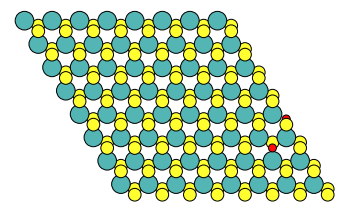

In [53]:
ax = plt.gca()
plot_defect_from_defect_type(dataset[370].initial_structure.copy(), dataset[370].defect_representation, ax)

In [75]:
def make_defect(structure, species, idx):
    return PeriodicSite(species, 
                        structure[idx].frac_coords, 
                        structure[idx].lattice)

In [76]:
make_defect(dataset[370].initial_structure, 
            dataset[370].defect_representation[1].species, 168)

PeriodicSite: X0+ (15.9516, 3.6839, 5.2846) [0.7083, 0.1667, 0.3552]

>>>
>>>


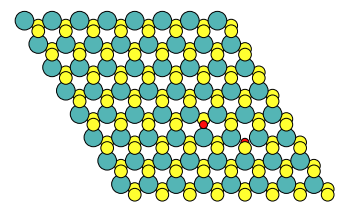

In [109]:
ax = plt.gca()
plot_defect_from_defect_type(dataset[1].initial_structure, 
                             dataset[1].defect_representation, ax)

In [96]:
dataset["X2_diff"]

,formation_energy,initial_structure,defect_representation,subgroup,group
idx,,,,,
1,5.3063,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[14.34365939 6.45412142 2.15745558] X0+, [9...",X2_diff,X2
4,5.3264,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 7.96302799 17.50569919 2.15745558] X0+, [-...",X2_diff,X2
208,5.3182,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-4.79823481 17.50569919 2.15745558] X0+, [ ...",X2_diff,X2
292,5.3250,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-7.98855051 17.50569919 2.15745558] X0+, [ ...",X2_diff,X2
370,5.3864,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[19.12913294 9.21701586 2.15745558] X0+, [1...",X2_diff,X2
398,5.3276,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[4.77271229 0.92833253 2.15745558] X0+, [ 6.3...",X2_diff,X2
453,5.3210,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[6.36787014 9.21701586 2.15745558] X0+, [15.9...",X2_diff,X2
500,5.3272,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,[[-1.27612628e-02 2.02685936e+01 2.15745558e...,X2_diff,X2
582,5.3141,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[14.34365939 11.9799103 2.15745558] X0+, [1...",X2_diff,X2


In [110]:
for i, row in dataset["X2"].iterrows():
    if dataset.checker.are_symmetrically_equivalent(row.defect_representation, Structure.from_sites(new_defect_conf)):
        print(i)

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


In [85]:
new_defect_conf = [make_defect(dataset[370].initial_structure, 
                               dataset[370].defect_representation[1].species, 
                               177),
                  dataset[370].defect_representation[0]]

In [88]:
dataset[370]

formation_energy                                                    5.3864
initial_structure        [[1.27612629e-07 1.84192955e+00 3.71975100e+00...
defect_representation    [[19.12913294  9.21701586  2.15745558] X0+, [1...
subgroup                                                           X2_diff
group                                                                   X2
Name: 370, dtype: object

In [114]:
MB = MatrixBuilder(dataset,"X2_diff")

In [115]:
MB.get_equivalent_idx(Structure.from_sites(new_defect_conf))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


370

In [118]:
MB.checker.are_symmetrically_equivalent(dataset[370].defect_representation, Structure.from_sites(new_defect_conf), symm_prec=0.01)

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


True

>>>
>>>


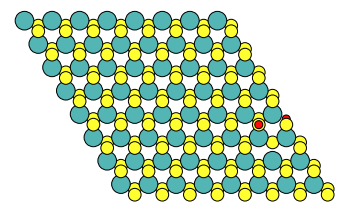

In [112]:
ax = plt.gca()
plot_defect_from_defect_type(dataset[370].initial_structure, 
                             new_defect_conf, ax)

In [124]:
sites1 = dataset[370].defect_representation.sites
sites2 = new_defect_conf
def in_sites(site):
    for test_site in sites1:
        if test_site.is_periodic_image(site, 0.01, False):
            return True
    return False
        
real_op = None
for op in dataset.checker:
    newsites2 = [PeriodicSite(site.species, op.operate(site.frac_coords), site.lattice) for site in sites2]
    for site in newsites2:
        if not in_sites(site):
            break
    else:
        real_op = op


In [125]:
real_op

Rot:
[[ 0. -1.  0.]
 [ 1. -1.  0.]
 [ 0.  0. -1.]]
tau
[0.25  0.875 0.5  ]

In [123]:
real_op

Rot:
[[-1.  1.  0.]
 [-1.  0.  0.]
 [ 0.  0. -1.]]
tau
[0.375 0.25  0.5  ]

In [119]:
checker.are_symmetrically_equivalent(dataset[370].defect_representation, new_defect_conf, symm_prec=0.01)

True

In [70]:
dataset[370].initial_structure[168].frac_coords

array([0.70833333, 0.16666667, 0.355174  ])

In [69]:
get_nn(dataset[370].initial_structure, dataset[370].defect_representation[1])

[168, 169, 176, 177, 184, 185]

In [59]:
find_site(dataset[370].initial_structure, dataset[370].defect_representation[0])

1

In [ ]:
num_x = 4
num_y = 4
offset = 18
fig, axes = plt.subplots(num_y, num_x, figsize=(18, 16))
plt.rc('axes', titlesize=10)
for i in range(num_x * num_y):
    ax = axes[i//num_x][i%num_x]
    index = i + offset
    initial_structure = s6_sample.iloc[index]['initial_structure']
    defects = s6_sample.iloc[index]['defect_representation']
    plot_defect_from_defect_type(initial_structure, defects, ax)

In [123]:
x2_same.adj_dict

{17: [230, 137, 165],
 45: [672, 769, 230, 17],
 137: [230],
 165: [137],
 230: [769],
 551: [551, 137],
 566: [230, 137, 551],
 672: [],
 769: [672]}

In [93]:
%time X2_MB = MatrixBuilder(dataset, 'X2')

CPU times: user 224 ms, sys: 228 ms, total: 452 ms
Wall time: 171 ms


In [94]:
%time ad = X2_MB.generate_group_adj_dict(how="DG", n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [97]:
gr = GroupResult("X2")

In [98]:
gr.build(ad, dataset)

In [99]:
gr.

672

In [159]:
dataset[x2_same.name].loc[672]

formation_energy                                                    5.2734
initial_structure        [[1.27612629e-07 1.84192955e+00 3.71975100e+00...
defect_representation    [[-3.20307696  9.21701586  2.15745558] X0+, [1...
subgroup                                                           X2_same
group                                                                   X2
Name: 672, dtype: object

In [192]:
def draw_local_mins_2_defects(gr, dataset):
    def get_distance(idx):
        defect_repr = dataset[idx].defect_representation
        return defect_repr[0].distance(defect_repr[1])
    def get_energy(idx):
        return dataset[idx].formation_energy
    plt.figure(figsize=(12,8))
    plt.scatter(get_distance(gr.min_e_idx), get_energy(gr.min_e_idx),
                c="green", label="Глобальный минимум")

    plt.scatter([get_distance(loc_min) for loc_min in gr.local_mins],
                [get_energy(loc_min) for loc_min in gr.local_mins],
                c="yellow", label="Локальный минимум")
    
    plt.scatter([get_distance(idx) for idx in gr.reached_global_min],
                [get_energy(idx) for idx in gr.reached_global_min],
                c="blue", label="Достигла глобального минимума")
    
    plt.scatter([get_distance(idx) for idx in gr.not_reached_global_min],
                [get_energy(idx) for idx in gr.not_reached_global_min],
                c="red", label="Не достигла глобального минимума")
    
    plt.ylabel("Энергия образования, эВ")
    plt.xlabel(r"Расстояние между дефектами, $\AA$")
    plt.title(f"{gr.name}", )
    plt.legend()

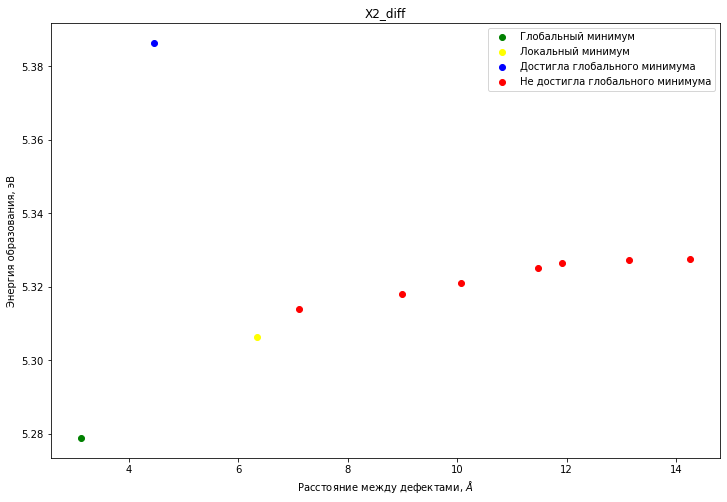

In [218]:
draw_local_mins_2_defects(x2_diff, dataset)

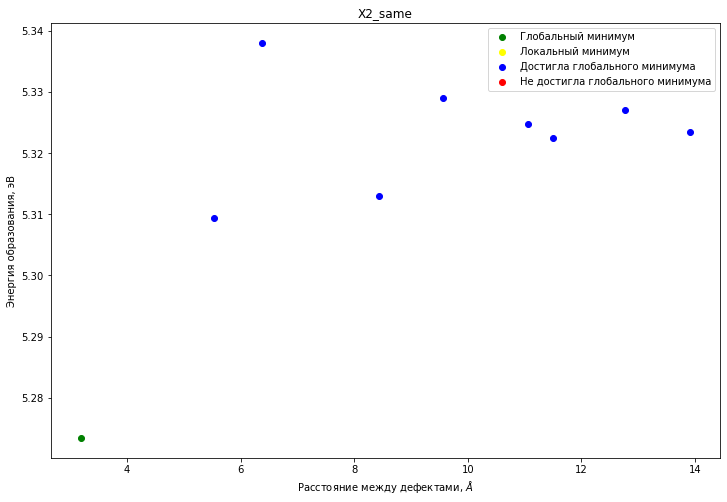

In [221]:
draw_local_mins_2_defects(x2_same, dataset)

In [220]:
x2_diff.adj_dict

{1: [],
 4: [292, 208, 453],
 208: [1, 582],
 292: [208],
 370: [1, 582, 597],
 398: [4, 292],
 453: [208, 582],
 500: [4, 453],
 582: [1],
 597: []}

In [101]:
gr.results

{1: end: 1, path: [1], reached_global_min: False.,
 4: end: 1, path: [4, 208, 1], reached_global_min: False.,
 17: end: 672, path: [17, 230, 769, 672], reached_global_min: True.,
 45: end: 672, path: [45, 672], reached_global_min: True.,
 137: end: 672, path: [137, 230, 769, 672], reached_global_min: True.,
 165: end: 672, path: [165, 137, 230, 769, 672], reached_global_min: True.,
 208: end: 1, path: [208, 1], reached_global_min: False.,
 230: end: 672, path: [230, 769, 672], reached_global_min: True.,
 292: end: 1, path: [292, 208, 1], reached_global_min: False.,
 370: end: 597, path: [370, 597], reached_global_min: False.,
 398: end: 1, path: [398, 4, 208, 1], reached_global_min: False.,
 453: end: 1, path: [453, 208, 1], reached_global_min: False.,
 500: end: 1, path: [500, 4, 208, 1], reached_global_min: False.,
 551: end: 672, path: [551, 137, 230, 769, 672], reached_global_min: True.,
 566: end: 672, path: [566, 230, 769, 672], reached_global_min: True.,
 582: end: 1, path: [582

In [103]:
d672 = dataset[672].defect_representation

In [104]:
d672[0].distance(d672[1])

3.1903156999999993

In [105]:
dataset[1].defect_representation[0].distance(dataset[1].defect_representation[1])

6.348024158304013

In [106]:
dataset[597].defect_representation[0].distance(dataset[597].defect_representation[1])

3.1245908399999998

In [55]:
ad

{1: [],
 4: [292, 208, 453],
 208: [208, 1, 582],
 292: [208],
 370: [1, 582, 597],
 398: [4, 292],
 453: [208, 582],
 500: [4, 453],
 582: [1],
 597: []}

In [72]:
graphs = dataset.data.defect_representation.apply(
    lambda x: nx.from_numpy_matrix(x.distance_matrix)
)
graphs[24]

In [12]:
def create_pbmol(defect_representation, title="title"):
    mol = openbabel.OBMol()
    n = len(defect_representation)
    for defect in defect_representation:
        a = mol.NewAtom()
        coords = defect.coords
        atomic_num = defect.specie.Z
        if defect.specie.symbol == 'X':
            atomic_num = 79 # Au is not present in dataset
        a.SetAtomicNum(atomic_num)
        a.SetVector(*coords)
    for i in range(n):
        for j in range(i+1, n, 1):
            mol.AddBond(i+1, j+1, 1)
    mol.SetTitle(title)
    return pybel.Molecule(mol)
        

In [114]:
# dataset.data.where(np.vectorize(same_ecfp)(dataset.data.ecfp2, dataset[24].ecfp2)).dropna()

In [20]:
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol, fprints_dict_from_sdf

In [56]:
def generate_e3fps(group_df, group_name):
    o_file_sdf = pybel.Outputfile("sdf", f"{group_name}_small.sdf", overwrite=True)
    for i, row in group_df.iterrows():
        pbmol = create_pbmol(row.defect_representation, str(i))
        o_file_sdf.write(pbmol)
    o_file_sdf.close()
    fps = []
    for mol in Chem.SDMolSupplier(f"{group_name}_small.sdf"):
        fps.append(fprints_dict_from_mol(mol)[5][0].bits)
    return fps

In [12]:
sample_V5_same_ad = restore_adj_dict('../../Downloads/V5_same')

In [25]:
import deepdiff
diff = deepdiff.DeepDiff(ad, sample_V5_same_ad, 
                         ignore_numeric_type_changes=True, ignore_order=True)
diff

{}

In [18]:
def check_reachable(adj_dict, min_idx):
    is_reachable = True
    digraph = nx.from_dict_of_lists(adj_dict, create_using=nx.DiGraph)
    for node in digraph:
        if not nx.has_path(digraph, node, min_idx):
            print(f"No path from {node} to {min_idx}!")
            is_reachable = False
    return is_reachable

In [141]:
plot3d(Structure.from_sites(get_sites_of_subgraph(graph,full_structure, dataset[2686].defect_representation)))

[53, 61, 6, 71]
[53, 61, 6, 135]
[71, 6, 135]


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [155]:
plot3d(Structure.from_sites(full_structure.sites+defects[1].sites))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [129]:
edge_match = iso.numerical_edge_match("weight", 0.0, atol=0.7)
node_match = lambda n1, n2: n1["specie"] == n2["specie"]

In [131]:
nx.is_isomorphic(make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               dataset[3082].defect_representation), 
                 make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               defects[1]))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


True

In [153]:
nx.weisfeiler_lehman_graph_hash(g3082)

'b03d2fb11fffb5acdef03c81511cd800'

In [155]:
nx.weisfeiler_lehman_graph_hash(make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               defects[1]))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


'b03d2fb11fffb5acdef03c81511cd800'

In [124]:
g3082 = make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               dataset[3082].defect_representation)
g3082.edges

EdgeView([(0, 2), (1, 6), (2, 3), (3, 7), (4, 5), (4, 7), (5, 6)])

In [126]:
g3082[5][6]

{'to_jimage': (0, 0, 0), 'weight': 3.1903156999999993}

In [99]:
make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               defects[1]).nodes[7]

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


{'specie': 'S',
 'coords': array([ 7.97578912, 11.97254266,  5.28463537]),
 'properties': {'was': None}}

In [278]:
dataset[214].defect_representation

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: X0+ (9.5837, 1.8346, 3.7198) [0.4170, 0.0830, 0.2500]
PeriodicSite: Se (-3.1903, 20.2612, 2.1549) [0.3333, 0.9167, 0.1448]
PeriodicSite: Se (20.7371, 6.4468, 2.1549) [0.9583, 0.2917, 0.1448]

In [279]:
dataset[215].defect_representation

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: W (14.3564, 4.6048, 3.7198) [0.6667, 0.2083, 0.2500]
PeriodicSite: X0+ (20.7243, 0.9283, 2.1575) [0.8330, 0.0420, 0.1450]
PeriodicSite: Se (14.3564, 17.4983, 2.1549) [0.9583, 0.7917, 0.1448]

In [233]:
def make_steiner_tree(structure_graph, full_structure, defect_representation):
    idx = [find_site(full_structure, defect) for defect in defect_representation]
    new_graph = nx.Graph(structure_graph.graph)
    for i, defect in enumerate(defect_representation):
        if defect.specie.symbol == "X":
            node = idx[i]
            for neighbor in new_graph.neighbors(node):
                # vacancies should have degree = 1 in resulting tree
                new_graph[node][neighbor]["weight"] *= 100
    return nx.algorithms.approximation.steiner_tree(new_graph, idx)

In [284]:
full_structure = dataset.get_full_structure()
%time graph = make_graph(full_structure)

CPU times: user 11.7 s, sys: 692 ms, total: 12.4 s
Wall time: 11.3 s


In [11]:
%time subgraphs = dataset.data.defect_representation.apply(make_subgraph)

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


CPU times: user 3min 51s, sys: 83.5 ms, total: 3min 51s
Wall time: 3min 52s


In [12]:
dataset.data["subgraph"] = subgraphs

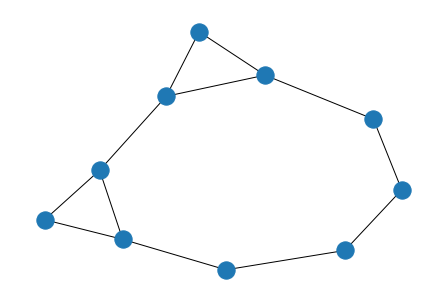

In [21]:
nx.draw(dataset[21].subgraph)

In [15]:
def check_all_groups(groups, data, checker):
    all_adjs = {}
    all_reachability = {}
    for group in tqdm(groups):
        group_df = data[data.group == group]
        all_adjs[group] = generate_group_adj_dict(group_df, checker)
        min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
        all_reachability[group] = check_reachable(all_adjs[group], 
                                                     min_idx)
    return all_adjs, all_reachability

In [16]:
from pymatgen.core.structure import Molecule, Element
from pymatgen.io.babel import BabelMolAdaptor

In [50]:
%time ad = generate_group_adj_dict(dataset['X2'], checker)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-3)]: Done   9 out of  19 | elapsed:    8.5s remaining:    9.4s
[Parallel(n_jobs=-3)]: Done  10 out of  19 | elapsed:    9.2s remaining:    8.3s
[Parallel(n_jobs=-3)]: Done  11 out of  19 | elapsed:    9.9s remaining:    7.2s
[Parallel(n_jobs=-3)]: Done  12 out of  19 | elapsed:   10.4s remaining:    6.1s
[Parallel(n_jobs=-3)]: Done  13 out of  19 | elapsed:   10.6s remaining:    4.9s
[Parallel(n_jobs=-3)]: 

In [51]:
ad

{1: [],
 4: [4, 292, 208, 453],
 17: [230, 137, 165],
 45: [672, 769, 230, 17],
 137: [137, 230],
 165: [137],
 208: [208, 1, 582],
 230: [230, 769],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 551: [551, 137],
 566: [230, 137, 551],
 582: [1],
 597: [],
 672: [672],
 769: [672]}

In [46]:
dataset['X2_diff'].loc[4]

energy_per_atom                                                  -7.287014
initial_structure        [[1.27612629e-07 1.84192955e+00 3.71975100e+00...
defect_representation    [[ 7.96302799 17.50569919  2.15745558] X0+, [-...
subgroup                                                           X2_diff
group                                                                   X2
Name: 4, dtype: object

In [20]:
def get_fp(defect_representation, fptype='ecfp8'):
    return create_pbmol(defect_representation).calcfp(fptype=fptype)

In [21]:
dataset.data['ecfp8'] = dataset.data.defect_representation.apply(get_fp)

In [123]:
def check_matr_repr(idx):
    ns, defect_reprs = generate_neighbouring_structures(
        dataset[idx].initial_structure, dataset[idx].defect_representation, checker
    )
    for defect_repr in defect_reprs:
        for i, row in dataset[dataset[idx].subgroup].iterrows():
            if checker.are_symmetrically_equivalent(defect_repr,
                                                row.defect_representation,
                                                symm_prec=0.01):
                assert matrices_are_isomofic(row.dist_matr, defect_repr.distance_matrix)
    

In [124]:
check_matr_repr(24)

In [88]:
def with_isomorfic_matr(defect_repr, m2):
    return matrices_are_isomofic(defect_repr.distance_matrix, 
                                 m2)
is24 = dataset.data[np.vectorize(matrices_are_isomofic, excluded=[1])(dataset.data.dist_matr,
                                                 dataset[24].defect_representation.distance_matrix)]

In [89]:
is24

,energy_per_atom,initial_structure,defect_representation,subgroup,group,dist_matr
idx,,,,,,
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"[[0.0, 8.181540959822657, 6.819087784854247], ..."
239,-7.282005,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.19031557 12.89350732 3.719751 ] W, [14....",S5_diff,S5,"[[0.0, 8.179869022801043, 6.823051215152787], ..."
1903,-7.289582,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,[[8.50750874e-08 7.36771851e+00 3.71975100e+00...,S6_diff,S6,"[[0.0, 6.8184941833112696, 8.179868856895947],..."
1938,-7.229946,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 12.88613968 3.719751 ] X0+, [1...",V3_diff,V3,"[[0.0, 6.814560204260533, 8.182744596837605], ..."
3574,-7.223203,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[20.74981331 4.59745635 3.719751 ] X0+, [ ...",V6_diff,V6,"[[0.0, 8.182744596837606, 6.819087784854248], ..."
4431,-7.222900,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[11.17886621 10.12324524 3.719751 ] X0+, [9...",V6_diff,V6,"[[0.0, 6.814560204260535, 8.181540909928607], ..."
4879,-7.296642,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-7.97578912 21.18219065 3.719751 ] W, [-6....",S3_diff,S3,"[[0.0, 6.812520560511897, 8.166103060233555], ..."
5872,-7.289554,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[6.38063149 7.36771851 3.719751 ] W, [1.5823...",S6_diff,S6,"[[0.0, 8.181046199364769, 6.823050976476825], ..."


In [99]:
dataset.data.where(dataset.data.ecfp2 | dataset[2917].ecfp2 > 0).dropna()

,energy_per_atom,initial_structure,defect_representation,subgroup,group,ecfp2,ecfp8
idx,,,,,,,
16,-7.230149,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-1.58239659 21.17482301 3.719751 ] X0+, [ ...",V3_same,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
21,-7.230071,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 9.58370836 18.41192856 3.719751 ] X0+, [1...",V3_diff,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
27,-7.215708,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 7.36035079 3.719751 ] X0+, [ ...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
28,-7.222900,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.17755444 18.41192856 3.719751 ] X0+, [3...",V6_same,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...
5928,-7.230001,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[12.77402406 7.36035079 3.719751 ] X0+, [-...",V3_same,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5929,-7.224031,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.17755444 7.36035079 3.719751 ] X0+, [3...",V6_diff,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."
5930,-7.222300,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,[[1.27612628e-02 1.28861397e+01 3.71975100e+00...,V6_diff,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."


In [122]:
def same_ecfp(fp1, fp2):
    return fp1.bits == fp2.bits

In [138]:
dataset.data[np.vectorize(same_ecfp)(dataset.data.ecfp8, get_fp(defects[5]))]

,energy_per_atom,initial_structure,defect_representation,subgroup,group,ecfp2,ecfp8
idx,,,,,,,
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
27,-7.215708,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 7.36035079 3.719751 ] X0+, [ ...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
35,-7.215566,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 1.60791911 21.17482301 3.719751 ] X0+, [1...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
41,-7.215624,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 12.88613968 3.719751 ] X0+, [1...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
49,-7.215592,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[7.98855051 4.59745635 3.719751 ] X0+, [14.3...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...
5583,-7.215606,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[0.01276126 7.36035079 3.719751 ] X0+, [17.5...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5584,-7.215618,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 4.79823481 15.64903412 3.719751 ] X0+, [1...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5611,-7.215591,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-4.77271229 15.64903412 3.719751 ] X0+, [4...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [113]:
# dataset.data[np.vectorize(same_ecfp)(dataset.data.ecfp8, dataset[9].ecfp8)]

In [143]:
from openbabel import openbabel, pybel

In [57]:
%time dct = generate_e3fps(dataset['V5_diff'], "v5_diff")

2022-06-14 20:45:22,291|INFO|Generating fingerprints for 24.
2022-06-14 20:45:22,295|INFO|Generated 1 fingerprints for 24.
2022-06-14 20:45:22,297|INFO|Generating fingerprints for 41.
2022-06-14 20:45:22,301|INFO|Generated 1 fingerprints for 41.
2022-06-14 20:45:22,302|INFO|Generating fingerprints for 69.
2022-06-14 20:45:22,307|INFO|Generated 1 fingerprints for 69.
2022-06-14 20:45:22,308|INFO|Generating fingerprints for 81.
2022-06-14 20:45:22,313|INFO|Generated 1 fingerprints for 81.
2022-06-14 20:45:22,315|INFO|Generating fingerprints for 91.
2022-06-14 20:45:22,320|INFO|Generated 1 fingerprints for 91.
2022-06-14 20:45:22,322|INFO|Generating fingerprints for 104.
2022-06-14 20:45:22,326|INFO|Generated 1 fingerprints for 104.
2022-06-14 20:45:22,327|INFO|Generating fingerprints for 120.
2022-06-14 20:45:22,331|INFO|Generated 1 fingerprints for 120.
2022-06-14 20:45:22,333|INFO|Generating fingerprints for 132.
2022-06-14 20:45:22,337|INFO|Generated 1 fingerprints for 132.
2022-06-14

2022-06-14 20:45:22,692|INFO|Generating fingerprints for 874.
2022-06-14 20:45:22,697|INFO|Generated 1 fingerprints for 874.
2022-06-14 20:45:22,698|INFO|Generating fingerprints for 884.
2022-06-14 20:45:22,703|INFO|Generated 1 fingerprints for 884.
2022-06-14 20:45:22,705|INFO|Generating fingerprints for 888.
2022-06-14 20:45:22,710|INFO|Generated 1 fingerprints for 888.
2022-06-14 20:45:22,711|INFO|Generating fingerprints for 935.
2022-06-14 20:45:22,717|INFO|Generated 1 fingerprints for 935.
2022-06-14 20:45:22,720|INFO|Generating fingerprints for 946.
2022-06-14 20:45:22,725|INFO|Generated 1 fingerprints for 946.
2022-06-14 20:45:22,726|INFO|Generating fingerprints for 961.
2022-06-14 20:45:22,731|INFO|Generated 1 fingerprints for 961.
2022-06-14 20:45:22,733|INFO|Generating fingerprints for 976.
2022-06-14 20:45:22,737|INFO|Generated 1 fingerprints for 976.
2022-06-14 20:45:22,739|INFO|Generating fingerprints for 1000.
2022-06-14 20:45:22,743|INFO|Generated 1 fingerprints for 1000

2022-06-14 20:45:23,102|INFO|Generating fingerprints for 1555.
2022-06-14 20:45:23,106|INFO|Generated 1 fingerprints for 1555.
2022-06-14 20:45:23,107|INFO|Generating fingerprints for 1564.
2022-06-14 20:45:23,111|INFO|Generated 1 fingerprints for 1564.
2022-06-14 20:45:23,112|INFO|Generating fingerprints for 1574.
2022-06-14 20:45:23,116|INFO|Generated 1 fingerprints for 1574.
2022-06-14 20:45:23,119|INFO|Generating fingerprints for 1576.
2022-06-14 20:45:23,124|INFO|Generated 1 fingerprints for 1576.
2022-06-14 20:45:23,126|INFO|Generating fingerprints for 1588.
2022-06-14 20:45:23,129|INFO|Generated 1 fingerprints for 1588.
2022-06-14 20:45:23,131|INFO|Generating fingerprints for 1602.
2022-06-14 20:45:23,136|INFO|Generated 1 fingerprints for 1602.
2022-06-14 20:45:23,138|INFO|Generating fingerprints for 1612.
2022-06-14 20:45:23,141|INFO|Generated 1 fingerprints for 1612.
2022-06-14 20:45:23,142|INFO|Generating fingerprints for 1615.
2022-06-14 20:45:23,147|INFO|Generated 1 fingerp

2022-06-14 20:45:23,513|INFO|Generating fingerprints for 2254.
2022-06-14 20:45:23,518|INFO|Generated 1 fingerprints for 2254.
2022-06-14 20:45:23,520|INFO|Generating fingerprints for 2264.
2022-06-14 20:45:23,525|INFO|Generated 1 fingerprints for 2264.
2022-06-14 20:45:23,526|INFO|Generating fingerprints for 2287.
2022-06-14 20:45:23,529|INFO|Generated 1 fingerprints for 2287.
2022-06-14 20:45:23,531|INFO|Generating fingerprints for 2290.
2022-06-14 20:45:23,535|INFO|Generated 1 fingerprints for 2290.
2022-06-14 20:45:23,536|INFO|Generating fingerprints for 2303.
2022-06-14 20:45:23,540|INFO|Generated 1 fingerprints for 2303.
2022-06-14 20:45:23,541|INFO|Generating fingerprints for 2311.
2022-06-14 20:45:23,544|INFO|Generated 1 fingerprints for 2311.
2022-06-14 20:45:23,546|INFO|Generating fingerprints for 2341.
2022-06-14 20:45:23,549|INFO|Generated 1 fingerprints for 2341.
2022-06-14 20:45:23,551|INFO|Generating fingerprints for 2362.
2022-06-14 20:45:23,556|INFO|Generated 1 fingerp

2022-06-14 20:45:23,914|INFO|Generating fingerprints for 2994.
2022-06-14 20:45:23,919|INFO|Generated 1 fingerprints for 2994.
2022-06-14 20:45:23,921|INFO|Generating fingerprints for 2999.
2022-06-14 20:45:23,925|INFO|Generated 1 fingerprints for 2999.
2022-06-14 20:45:23,927|INFO|Generating fingerprints for 3006.
2022-06-14 20:45:23,932|INFO|Generated 1 fingerprints for 3006.
2022-06-14 20:45:23,934|INFO|Generating fingerprints for 3017.
2022-06-14 20:45:23,938|INFO|Generated 1 fingerprints for 3017.
2022-06-14 20:45:23,940|INFO|Generating fingerprints for 3032.
2022-06-14 20:45:23,944|INFO|Generated 1 fingerprints for 3032.
2022-06-14 20:45:23,945|INFO|Generating fingerprints for 3060.
2022-06-14 20:45:23,949|INFO|Generated 1 fingerprints for 3060.
2022-06-14 20:45:23,952|INFO|Generating fingerprints for 3065.
2022-06-14 20:45:23,955|INFO|Generated 1 fingerprints for 3065.
2022-06-14 20:45:23,957|INFO|Generating fingerprints for 3077.
2022-06-14 20:45:23,960|INFO|Generated 1 fingerp

2022-06-14 20:45:24,346|INFO|Generating fingerprints for 4034.
2022-06-14 20:45:24,350|INFO|Generated 1 fingerprints for 4034.
2022-06-14 20:45:24,352|INFO|Generating fingerprints for 4040.
2022-06-14 20:45:24,356|INFO|Generated 1 fingerprints for 4040.
2022-06-14 20:45:24,358|INFO|Generating fingerprints for 4064.
2022-06-14 20:45:24,362|INFO|Generated 1 fingerprints for 4064.
2022-06-14 20:45:24,365|INFO|Generating fingerprints for 4082.
2022-06-14 20:45:24,370|INFO|Generated 1 fingerprints for 4082.
2022-06-14 20:45:24,373|INFO|Generating fingerprints for 4102.
2022-06-14 20:45:24,378|INFO|Generated 1 fingerprints for 4102.
2022-06-14 20:45:24,380|INFO|Generating fingerprints for 4104.
2022-06-14 20:45:24,384|INFO|Generated 1 fingerprints for 4104.
2022-06-14 20:45:24,386|INFO|Generating fingerprints for 4154.
2022-06-14 20:45:24,391|INFO|Generated 1 fingerprints for 4154.
2022-06-14 20:45:24,393|INFO|Generating fingerprints for 4159.
2022-06-14 20:45:24,396|INFO|Generated 1 fingerp

CPU times: user 2.44 s, sys: 257 ms, total: 2.7 s
Wall time: 2.46 s


In [9]:
pbmol = create_pbmol(d24)

In [10]:
pbmol.draw()

In [11]:
pbmol.write("sdf", "outputfile.sdf", overwrite=True)

In [35]:
from rdkit import Chem

In [61]:
fps = []
for mol in Chem.SDMolSupplier('X2_diff_small.sdf'):
    fps.append(fprints_dict_from_mol(mol, level=1)[1][0].bits)
fps

2022-06-14 20:49:26,332|INFO|Generating fingerprints for 1.
2022-06-14 20:49:26,339|INFO|Generated 1 fingerprints for 1.
2022-06-14 20:49:26,341|INFO|Generating fingerprints for 4.
2022-06-14 20:49:26,345|INFO|Generated 1 fingerprints for 4.
2022-06-14 20:49:26,348|INFO|Generating fingerprints for 208.
2022-06-14 20:49:26,353|INFO|Generated 1 fingerprints for 208.
2022-06-14 20:49:26,355|INFO|Generating fingerprints for 292.
2022-06-14 20:49:26,359|INFO|Generated 1 fingerprints for 292.
2022-06-14 20:49:26,361|INFO|Generating fingerprints for 370.
2022-06-14 20:49:26,364|INFO|Generated 1 fingerprints for 370.
2022-06-14 20:49:26,366|INFO|Generating fingerprints for 398.
2022-06-14 20:49:26,370|INFO|Generated 1 fingerprints for 398.
2022-06-14 20:49:26,371|INFO|Generating fingerprints for 453.
2022-06-14 20:49:26,376|INFO|Generated 1 fingerprints for 453.
2022-06-14 20:49:26,377|INFO|Generating fingerprints for 500.
2022-06-14 20:49:26,382|INFO|Generated 1 fingerprints for 500.
2022-06-

[4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296]

In [41]:
len(rdmol)

10

In [40]:
with open("outputfile.sdf", "rb") as f:
    supplier = Chem.ForwardSDMolSupplier(f)

In [41]:
mol = next(rdmol)

In [18]:
from e3fp.conformer.util import mol_from_sdf

In [43]:
fprints_dict_from_sdf('outputfile.sdf')

{5: [Fingerprint(indices=array([2587607838, 3027952810]), level=5, bits=4294967296, name=ttl_0)]}

In [26]:
dct = fprints_dict_from_mol(mol)

In [33]:
dct[5][0].bits

4294967296

In [54]:
import pybel

In [43]:
pybel.Fingerprint()

['ecfp0',
 'ecfp10',
 'ecfp2',
 'ecfp4',
 'ecfp6',
 'ecfp8',
 'fp2',
 'fp3',
 'fp4',
 'maccs']

In [242]:
from pymatgen.core import Molecule

In [88]:
conn = MinimumDistanceNN(cutoff=3.2, get_all_sites=True)

In [92]:
conn = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0)

In [73]:
full_structure[18]

PeriodicSite: Mo (3.1903, 7.3677, 3.7198) [0.2917, 0.3333, 0.2500]

In [105]:
from pymatgen.analysis.local_env import MinimumVIRENN

In [106]:
conn = MinimumVIRENN()

In [107]:
conn.get_nn(full_structure, 121)

[PeriodicSite: S2- (22.3322, -1.8419, 2.1549) [0.8333, -0.0833, 0.1448],
 PeriodicSite: S2- (22.3322, 3.6839, 2.1549) [0.9583, 0.1667, 0.1448],
 PeriodicSite: S2- (20.7371, 0.9210, 2.1549) [0.8333, 0.0417, 0.1448],
 PeriodicSite: Mo4+ (22.3322, 1.8419, 3.7198) [0.9167, 0.0833, 0.2500],
 PeriodicSite: S2- (25.5225, -1.8419, 2.1549) [0.9583, -0.0833, 0.1448],
 PeriodicSite: Mo4+ (23.9274, -0.9210, 3.7198) [0.9167, -0.0417, 0.2500],
 PeriodicSite: S2- (25.5225, 3.6839, 2.1549) [1.0833, 0.1667, 0.1448],
 PeriodicSite: S2- (27.1177, 0.9210, 2.1549) [1.0833, 0.0417, 0.1448],
 PeriodicSite: Mo4+ (25.5225, 1.8419, 3.7198) [1.0417, 0.0833, 0.2500],
 PeriodicSite: S2- (23.9274, 0.9210, 5.2846) [0.9583, 0.0417, 0.3552]]

In [105]:
graph = StructureGraph.with_local_env_strategy(
    dataset.get_full_structure(), 
    MinimumDistanceNN(cutoff=get_r(dataset.get_full_structure()), 
                      get_all_sites=True),
    weights=True
)

In [164]:
def create_large_pbmol(structure, defect_representation, graph, title="title"):
    mol = openbabel.OBMol()
    n = len(defect_representation)
    idx = [find_site(structure, d) for d in defect_representation]
    atom_idxs = {} # structure site idx: molecule atom idx
    for i in range(n):
        a = mol.NewAtom()
        coords = defect_representation[i].coords
        atomic_num = defect_representation[i].specie.Z
        if defect_representation[i].specie.symbol == 'X':
            atomic_num = 79 # Au is not present in dataset
        a.SetAtomicNum(atomic_num)
        a.SetVector(*coords)
        atom_idxs[idx[i]] = mol.NumAtoms
    for i in range(n):
        for j in range(i+1, n, 1):
            path = nx.shortest_path(graph, idx[i], 
                                    idx[j], weight="weight")
            print(path)
            for k in range(1, len(path)-1, 1):
                a = mol.NewAtom()
                coords = structure[path[k]].coords
                atomic_num = structure[path[k]].specie.Z
                atom_idxs[path[k]] = mol.NumAtoms
                mol.AddBond(path[k-1], path[k], 1)    
    mol.SetTitle(title)
    return pybel.Molecule(mol)

In [316]:
plot3d(Structure.from_sites(sg))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [208]:
dataset[24].initial_structure.get_sites_in_sphere(
                d24_0.coords, get_r(dataset[24].initial_structure), include_index=True
            )[0].nn_distance

2.4225868164540314

In [212]:
def get_neighbors(structure, defect_site):
    return {nn.index: nn.nn_distance for nn in structure.get_sites_in_sphere(
                defect_site.coords, get_r(structure), include_index=True
    )}

In [314]:
%time graph = make_graph(full_structure)

CPU times: user 10.4 s, sys: 62.3 ms, total: 10.5 s
Wall time: 9.54 s


In [165]:
pbmol = create_large_pbmol(dataset[24].initial_structure,
                          dataset[24].defect_representation,
                          nx.Graph(graph.graph))

ValueError: [3.20307696 7.36035079 3.719751  ] X0+ not found in structure with atol=0.1

In [163]:
pbmol.draw()

In [134]:
graph.get_connected_sites(0)

[ConnectedSite(site=PeriodicSite: S (1.5952, 0.9210, 2.1549) [0.0833, 0.0417, 0.1448], jimage=(0, 0, 0), index=65, weight=2.4169333360037606, dist=2.4169333360037606),
 ConnectedSite(site=PeriodicSite: S (1.5952, 0.9210, 5.2846) [0.0833, 0.0417, 0.3552], jimage=(0, 0, 0), index=129, weight=2.4169333360037597, dist=2.4169333360037606),
 ConnectedSite(site=PeriodicSite: S (-0.0000, 3.6839, 2.1549) [0.0833, 0.1667, 0.1448], jimage=(0, 0, 0), index=66, weight=2.416933672897242, dist=2.416933672897242),
 ConnectedSite(site=PeriodicSite: S (-1.5952, 0.9210, 5.2846) [-0.0417, 0.0417, 0.3552], jimage=(-1, 0, 0), index=184, weight=2.416933672897243, dist=2.4169336728972426),
 ConnectedSite(site=PeriodicSite: S (-1.5952, 0.9210, 2.1549) [-0.0417, 0.0417, 0.1448], jimage=(-1, 0, 0), index=121, weight=2.4169336728972435, dist=2.4169336728972426),
 ConnectedSite(site=PeriodicSite: S (-0.0000, 3.6839, 5.2846) [0.0833, 0.1667, 0.3552], jimage=(0, 0, 0), index=130, weight=2.4169336728972413, dist=2.41

In [8]:
get_nn(dataset[0].initial_structure, dataset[0].initial_structure[0])

[1, 7, 8, 9, 56, 63]

In [64]:
from pymatgen.core import Structure

In [94]:
def get_r(structure, size=(8,8,3)):
    ls = np.array(structure.lattice.lengths) / size
    return np.sqrt(np.sum(np.square(ls))) / 2

In [26]:
ad = generate_group_adj_dict(dataset.get_subgroup_df('X2_diff'), checker)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done   2 out of  10 | elapsed:    3.5s remaining:   13.8s
[Parallel(n_jobs=-3)]: Done   3 out of  10 | elapsed:    3.6s remaining:    8.3s
[Parallel(n_jobs=-3)]: Done   4 out of  10 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-3)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-3)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.7s
[Parallel(n_jobs=-3)]: Done   7 out of  10 | elapsed:    5.7s remaining:    2.5s
[Parallel(n_jobs=-3)]: Done   8 out of  10 | elapsed:    6.0s remaining:    1.5s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s finished


In [23]:
ad

{1: [],
 4: [4, 292, 208, 453],
 208: [208, 1, 582],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 582: [1],
 597: []}

In [24]:
check_reachable(ad, dataset.subgroup_energy_argmin_idx('X2_diff'))

No path from 1 to 597!
No path from 4 to 597!
No path from 208 to 597!
No path from 292 to 597!
No path from 398 to 597!
No path from 453 to 597!
No path from 500 to 597!
No path from 582 to 597!


False

In [14]:
pmg_mol = Molecule([site.species for site in d24], [[int(c*100) for c in site.coords] for site in d24 ])
pmg_mol

NameError: name 'Molecule' is not defined

In [83]:
spectromaker = pybel.ob.OBSpectrophore()

In [84]:
myspec = spectromaker.GetSpectrophore(pbmol.OBMol)

In [ ]:
dataset.data[dataset.data.idx == 597]

In [23]:
%time ad = generate_group_adj_dict(dataset.get_group_df('X2'), checker)
check_reachable(ad, dataset.group_energy_argmin_idx('X2'))

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   9 out of  13 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-3)]: Done  10 out of  13 | elapsed:    2.3s remaining:    0.7s
[Parallel(n_jobs=-3)]: Done  11 out of  13 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-3)]: Done  13 out of  13 | elapsed:    2.3s remaining:    0.0s


AttributeError: 'Series' object has no attribute 'idx'

NameError: name 'ad' is not defined

In [ ]:
dataset.get_subgroup_df('X2_diff')

In [ ]:
assert False

In [ ]:
group = 'X5'
group_df = data[data.group == group]
adj_dict = generate_group_adj_dict(group_df, checker)
min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
check_reachable(adj_dict, min_idx)

In [ ]:
%time
all_adjs, all_reachability = check_all_groups(data.group.unique(), data, 
                                                 checker)

In [8]:
df_x5_diff = dataset.get_subgroup_df('X5_diff')

In [9]:
y = df_x5_diff.energy_per_atom

In [10]:
x = []
for defect_repr in df_x5_diff.defect_representation:
    x.append(defect_repr[0].distance(defect_repr[1]))

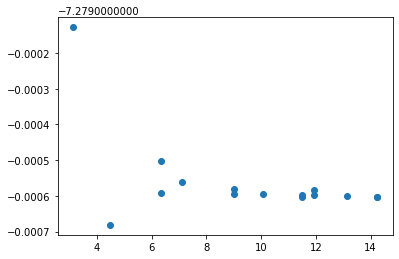

In [11]:
plt.scatter(x, y)

In [76]:
1

1